# Load Data and Modules Needed

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [2]:
file_train = "~/ds/proj3/tanzania-water-wells/data/raw/training-set-values.csv" #x_train, training set values data
file_target_train = "~/ds/proj3/tanzania-water-wells/data/raw/training-labels.csv" #y_train, training set labels
file_test = "~/ds/proj3/tanzania-water-wells/data/raw/test-set.csv" #x_test, test set data

In [3]:
features = pd.read_csv(file_train)
targets = pd.read_csv(file_target_train)
X_test = pd.read_csv(file_test)

# EDA

In [219]:
targets['status_group'].value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

In [220]:
features.dtypes

id                         int64
amount_tsh               float64
date_recorded             object
funder                    object
gps_height                 int64
installer                 object
longitude                float64
latitude                 float64
wpt_name                  object
num_private                int64
basin                     object
subvillage                object
region                    object
region_code                int64
district_code              int64
lga                       object
ward                      object
population                 int64
public_meeting            object
recorded_by               object
scheme_management         object
scheme_name               object
permit                    object
construction_year          int64
extraction_type           object
extraction_type_group     object
extraction_type_class     object
management                object
management_group          object
payment                   object
payment_ty

## Definitely an imbalance in the training target data, and there are a lot of categorical features!

There are also several features that look very related, source/source_type, waterpoint_type/waterpoint_type_group, payment/payment_type, etc. 

In [6]:
wells = features.copy()

In [222]:
wells['waterpoint_type'].value_counts()

communal standpipe             28522
hand pump                      17488
other                           6380
communal standpipe multiple     6103
improved spring                  784
cattle trough                    116
dam                                7
Name: waterpoint_type, dtype: int64

In [160]:
wells['waterpoint_type_group'].value_counts()

communal standpipe    34625
hand pump             17488
other                  6380
improved spring         784
cattle trough           116
dam                       7
Name: waterpoint_type_group, dtype: int64

quantity and quantity_group are literal copies of eachother

In [162]:
wells['quantity'].value_counts()

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity, dtype: int64

In [161]:
wells['quantity_group'].value_counts()

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity_group, dtype: int64

Management is harder to tell..

In [174]:
wells['management'].value_counts()

vwc                 40507
wug                  6515
water board          2933
wua                  2535
private operator     1971
parastatal           1768
water authority       904
other                 844
company               685
unknown               561
other - school         99
trust                  78
Name: management, dtype: int64

In [173]:
wells['management_group'].value_counts()

user-group    52490
commercial     3638
parastatal     1768
other           943
unknown         561
Name: management_group, dtype: int64

I like type, besides dam all of the types seem to numerous

In [175]:
wells['source_type'].value_counts()

spring                  17021
shallow well            16824
borehole                11949
river/lake              10377
rainwater harvesting     2295
dam                       656
other                     278
Name: source_type, dtype: int64

In [176]:
wells['source_class'].value_counts()

groundwater    45794
surface        13328
unknown          278
Name: source_class, dtype: int64

In [198]:
wells['payment'].value_counts()

never pay                25348
pay per bucket            8985
pay monthly               8300
unknown                   8157
pay when scheme fails     3914
pay annually              3642
other                     1054
Name: payment, dtype: int64

In [201]:
wells['payment_type'].value_counts()

never pay     25348
per bucket     8985
monthly        8300
unknown        8157
on failure     3914
annually       3642
other          1054
Name: payment_type, dtype: int64

In [203]:
wells['water_quality'].value_counts()

soft                  50818
salty                  4856
unknown                1876
milky                   804
coloured                490
salty abandoned         339
fluoride                200
fluoride abandoned       17
Name: water_quality, dtype: int64

In [204]:
wells['quality_group'].value_counts()

good        50818
salty        5195
unknown      1876
milky         804
colored       490
fluoride      217
Name: quality_group, dtype: int64

In [211]:
wells['funder'].value_counts()

Government Of Tanzania    9084
Danida                    3114
Hesawa                    2202
Rwssp                     1374
World Bank                1349
                          ... 
Seronera                     1
Mh.J S Sumari                1
Mganga                       1
Rc Njoro                     1
Songa Hospi                  1
Name: funder, Length: 1897, dtype: int64

In [212]:
wells['installer'].value_counts()

DWE                   17402
Government             1825
RWE                    1206
Commu                  1060
DANIDA                 1050
                      ...  
Water Authority           1
Kuwaiti                   1
Claver                    1
ACT MARA                  1
Pet Coporation Ltd        1
Name: installer, Length: 2145, dtype: int64

In [279]:
wells['subvillage'].value_counts()

Madukani     508
Shuleni      506
Majengo      502
Kati         373
Mtakuja      262
            ... 
49             1
Ukingi         1
Ipiriri A      1
Sumba          1
Mienda A       1
Name: subvillage, Length: 19287, dtype: int64

### Let's look at how the numerical data is correlated:

In [223]:
wells.corr()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
id,1.000000,-0.005321,-0.004692,-0.001348,0.001718,-0.002629,-0.003028,-0.003044,-0.002813,-0.002082
amount_tsh,-0.005321,1.000000,0.076650,0.022134,-0.052670,0.002944,-0.026813,-0.023599,0.016288,0.067915
gps_height,-0.004692,0.076650,1.000000,0.149155,-0.035751,0.007237,-0.183521,-0.171233,0.135003,0.658727
longitude,-0.001348,0.022134,0.149155,1.000000,-0.425802,0.023873,0.034197,0.151398,0.086590,0.396732
latitude,0.001718,-0.052670,-0.035751,-0.425802,1.000000,0.006837,-0.221018,-0.201020,-0.022152,-0.245278
num_private,-0.002629,0.002944,0.007237,0.023873,0.006837,1.000000,-0.020377,-0.004478,0.003818,0.026056
region_code,-0.003028,-0.026813,-0.183521,0.034197,-0.221018,-0.020377,1.000000,0.678602,0.094088,0.031724
district_code,-0.003044,-0.023599,-0.171233,0.151398,-0.201020,-0.004478,0.678602,1.000000,0.061831,0.048315
population,-0.002813,0.016288,0.135003,0.086590,-0.022152,0.003818,0.094088,0.061831,1.000000,0.260910
construction_year,-0.002082,0.067915,0.658727,0.396732,-0.245278,0.026056,0.031724,0.048315,0.260910,1.000000


district_code and region_code have a high correlation, but instinctually this would make sense as they are probably related. population shows some correlation to construction_year, but this is probably not normalized to the growth in population over time. Something to note is that construction_year and gps_height have the highest correlation - is there something allowing them to build at higher elevations that was not possible previously? 

This made us consider other technological innovations. extraction_type, extraction_type_class and extraction_type_group possibly fit the bill. 

In [110]:
wells['construction_year'].value_counts()

0       20709
2010     2645
2008     2613
2009     2533
2000     2091
2007     1587
2006     1471
2003     1286
2011     1256
2004     1123
2012     1084
2002     1075
1978     1037
1995     1014
2005     1011
1999      979
1998      966
1990      954
1985      945
1980      811
1996      811
1984      779
1982      744
1994      738
1972      708
1974      676
1997      644
1992      640
1993      608
2001      540
1988      521
1983      488
1975      437
1986      434
1976      414
1970      411
1991      324
1989      316
1987      302
1981      238
1977      202
1979      192
1973      184
2013      176
1971      145
1960      102
1967       88
1963       85
1968       77
1969       59
1964       40
1962       30
1961       21
1965       19
1966       17
Name: construction_year, dtype: int64

### Uh-oh
Over 1/3 of the data has a 0 for construction year. What are these three different groups, and how are the non-zeroes correlated with extraction type?

In [111]:
wells['extraction_type_class'].value_counts()

gravity         26780
handpump        16456
other            6430
submersible      6179
motorpump        2987
rope pump         451
wind-powered      117
Name: extraction_type_class, dtype: int64

In [112]:
wells['extraction_type'].value_counts()

gravity                      26780
nira/tanira                   8154
other                         6430
submersible                   4764
swn 80                        3670
mono                          2865
india mark ii                 2400
afridev                       1770
ksb                           1415
other - rope pump              451
other - swn 81                 229
windmill                       117
india mark iii                  98
cemo                            90
other - play pump               85
walimi                          48
climax                          32
other - mkulima/shinyanga        2
Name: extraction_type, dtype: int64

In [113]:
wells['extraction_type_group'].value_counts()

gravity            26780
nira/tanira         8154
other               6430
submersible         6179
swn 80              3670
mono                2865
india mark ii       2400
afridev             1770
rope pump            451
other handpump       364
other motorpump      122
wind-powered         117
india mark iii        98
Name: extraction_type_group, dtype: int64

In [8]:
con_year_nonzero = wells.copy()

con_year_nonzero = con_year_nonzero.replace(0, np.nan)
con_year_nonzero = con_year_nonzero.dropna(how='all', axis=1)

In [9]:
con_year_nonzero['construction_year'].value_counts().sum()

38691

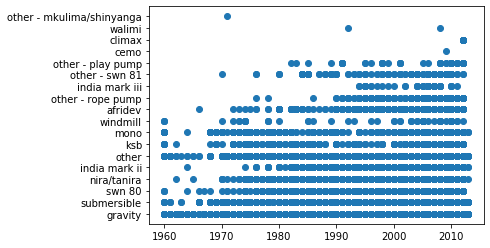

In [13]:
plt.scatter(con_year_nonzero['construction_year'],con_year_nonzero['extraction_type'])

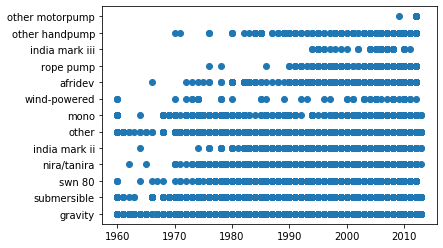

In [148]:
plt.scatter(con_year_nonzero2['construction_year'],con_year_nonzero['extraction_type_group'])

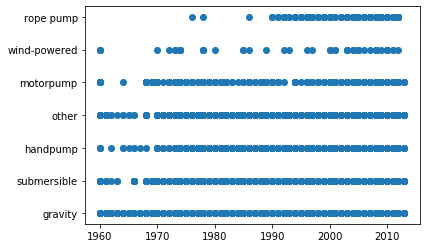

In [149]:
plt.scatter(con_year_nonzero2['construction_year'],con_year_nonzero['extraction_type_class'])

In [10]:
avg_con_years = pd.DataFrame(con_year_nonzero.groupby(['extraction_type']).mean()['construction_year'])
avg_con_years

,construction_year
extraction_type,
afridev,2002.316821
cemo,2009.000000
climax,2012.000000
gravity,1995.965949
india mark ii,2001.308428
india mark iii,2004.126984
ksb,1999.250000
mono,1992.634541
nira/tanira,1999.421166


In [14]:
wells_test = wells.copy()
wells_test = pd.concat([wells_test,avg_con_years],keys=['extraction_type'])
avg_con_years['construction_year'] = avg_con_years['construction_year'].astype(int)
wells_test = wells_test.join(avg_con_years, rsuffix='avg', on='extraction_type') 
wells_test = wells_test.reset_index()
wells_test = wells_test.drop(['level_0','level_1'],axis=1)
wells_test

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,construction_yearavg
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,1995
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,1995
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,1995
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,1999
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,1995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,60739,10.0,2013-05-03,Germany Republi,1210,CES,37.169807,-3.253847,Area Three Namba 27,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,1995
59396,27263,4700.0,2011-05-07,Cefa-njombe,1212,Cefa,35.249991,-9.070629,Kwa Yahona Kuvala,0,...,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,1995
59397,37057,0.0,2011-04-11,NaN,0,NaN,34.017087,-8.750434,Mashine,0,...,fluoride,fluoride,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump,1996
59398,31282,0.0,2011-03-08,Malec,0,Musa,35.861315,-6.378573,Mshoro,0,...,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,1999


In [15]:
def con_year(row: pd.DataFrame) -> int:
        ## This function replaces 
        if (row['construction_year'] == 0):
            return row['construction_yearavg']
        else:
            return row['construction_year']
            print('same')
wells_test['construction_year'] = wells_test.apply(con_year, axis=1)

In [16]:
wells_test['construction_year'] = wells_test.apply(con_year, axis=1)

In [17]:
wells_test['construction_year'].value_counts()

1995    7880
1999    7491
1993    3275
2010    2645
2009    2622
2008    2613
1996    2284
2000    2190
1992    1959
2002    1911
2007    1587
2006    1471
2003    1286
2001    1267
2011    1256
2004    1158
2012    1108
2005    1072
1978    1037
1998     966
1990     954
1985     945
1980     811
1984     779
1982     744
1994     738
1972     708
1974     676
1997     644
1988     521
1983     488
1975     437
1986     434
1976     414
1970     411
1991     324
1989     316
1987     302
1981     238
1977     202
1979     192
1973     184
2013     176
1971     146
1960     102
1967      88
1963      85
1968      77
1969      59
1964      40
1962      30
1961      21
1965      19
1966      17
Name: construction_year, dtype: int64

# Building A Base Model

Since we are limited to our number of submissions to the contest daily, we will train/test split the provided training data to create iterative models

### Split into train/test

In [106]:
X_train, X_test, y_train, y_test = train_test_split(features, targets, random_state=42)

In [73]:
features_list = ['basin', 'region',
       'scheme_management', 'scheme_name',
       'extraction_type',
       'management', 'payment', 
       'water_quality', 'quantity',
       'source', 'waterpoint_type','gps_height', 'longitude', 'latitude', 'num_private', 
        'region_code', 'district_code', 'population', 'construction_year']   


In [82]:
wells['source_type'].value_counts()

spring                  17021
shallow well            16824
borehole                11949
river/lake              10377
rainwater harvesting     2295
dam                       656
other                     278
Name: source_type, dtype: int64

In [83]:
wells['source'].value_counts()

spring                  17021
shallow well            16824
machine dbh             11075
river                    9612
rainwater harvesting     2295
hand dtw                  874
lake                      765
dam                       656
other                     212
unknown                    66
Name: source, dtype: int64

### Cleaning Data

In [163]:
wells = features.copy()
wells.shape

(59400, 40)

In [201]:
def numerical_clean(df, feature_list):
    #this takes the df and the list of numerical features to clean
    df = df[feature_list]
    
    df = drop_zero_long(df)
    df = con_year_avg(df)
    return df

In [135]:
## this is in numerical clean function
def drop_zero_long(df):
    return df.drop(df[df.longitude==0].index)
# wells2 = wells.drop(wells[wells.longitude==0].index)
# wells2

In [155]:
def con_year(row: pd.DataFrame) -> int:
        ## This function replaces rows with contruction_year == 0 with the average year based upon their extractor type
        if (row['construction_year'] == 0):
            return row['construction_year_avg']
        else:
            return row['construction_year']

In [273]:
def con_year_avg(df):
    con_year_nonzero = df.replace(0, np.nan)
#     con_year_nonzero = con_year_nonzero.dropna(how='all', axis=1) don't think we need this
    avg_con_years = pd.DataFrame(con_year_nonzero.groupby(['extraction_type']).mean()['construction_year'])
#     avg_con_years['construction_year'] = avg_con_years['construction_year'].astype(int)
    df = df.join(avg_con_years, rsuffix = '_avg', on = 'extraction_type')
    df = df.reset_index()
    df = df.drop(['index'], axis = 1)
    df['construction_year'] = wells_test.apply(con_year, axis=1)
    df = df.drop(['construction_year_avg'], axis = 1)
    return df

In [160]:
test = con_year_avg(wells)
# test.construction_year.value_counts()

In [180]:
test = numerical_clean(wells)

In [217]:
# this is with no list
# def obj_preprocessing(df):
#     '''
#     '''
#     # Clean the df if there are NaNs
#     df = NaN_cleaning(df)
#     #OHE data
#     array_current = ohe_data(df)
#     #return a dataframe of the OHE data
#     return pd.DataFrame(array_current)

# def ohe_data(df):
#     #OHE the data
#     onehotencoder = OneHotEncoder() # Instantiate a One Hot Encoder object 
#     print('One hot encoding data')
#     array_current = onehotencoder.fit_transform(df).toarray()
#     return array_current

# def NaN_cleaning(df):
#     # Replace NaN with "unknown" bin
#     print('Cleaning the data')
#     df = df.replace(np.nan, 'unknown')
#     print(f'Check: Number of rows with nulls: {len(df[df.isna().any(axis=1)])}')
#     return df

In [414]:
# this is with list
def obj_preprocessing(df, obj_list, ohe, train = True):
    '''
    '''
    df_current = df[obj_list]
    # Clean the df if there are NaNs
    df = NaN_cleaning(df_current)
    #OHE data
    array_current = ohe_data(df, ohe, train)
    #return a dataframe of the OHE data
    return pd.DataFrame(array_current)

def ohe_data(df, ohe, train):
    #OHE the data
    print('One hot encoding data')
    if train:
        array_current = ohe.fit_transform(df).toarray()
    else:
        array_current = ohe.transform(df).toarray()
    return array_current

def NaN_cleaning(df):
    # Replace NaN with "unknown" bin
    print('Cleaning the data')
    df = df.replace(np.nan, 'unknown')
    print(f'Check: Number of rows with nulls: {len(df[df.isna().any(axis=1)])}')
    return df

In [189]:
obj_pp = obj_preprocessing(objects)

Cleaning the data
Check: Number of rows with nulls: 0
One hot encoding data


# FINAL? WORKING PIPELINE

In [443]:
# Be sure to train/test split before processing DFs
def model_preprocessing(df, feature_list, ohe, train=True):
    df = numerical_clean(df,feature_list)
    
    # below should probably be a funciton for cleanliness
    target = df['status_group']
    df = df.drop(columns='status_group', axis = 1)
#     print(df['status_group'])
    obj_list = obj_lister(df)
    ohe_df = obj_preprocessing(df, obj_list, ohe, train)
    df = df.drop(obj_list, axis=1)
    model_df = df.join(ohe_df)
    return model_df, target

## Work below

In [206]:
wells = features.copy()
wells.shape

(59400, 40)

In [289]:
features_list = ['basin', 'region',
       'scheme_management', 'scheme_name',
       'extraction_type',
       'management', 'payment', 
       'water_quality', 'quantity',
       'source', 'waterpoint_type','gps_height', 'longitude', 'latitude', 
        'region_code', 'district_code', 'population', 'construction_year', 'status_group']   


In [233]:
def obj_lister(df):
    # returns a list of columns that contain Objects
    obj_list = []
    for col in df.select_dtypes([np.object]):
        obj_list.append(col)
    return obj_list

In [227]:
## might not need this
# def ohe_splitter(df):
#     # this is the second step of the pipeline, after train/test split, splitting feature list into objects and numerical lists, for more
#     # processing
#     obj_list = []
    
#     ## appends lists with columns based upon their dtypes
#     for col in df.select_dtypes([np.object]):
#         obj_list.append(col)
#     num_df = df.drop(obj_list)
#     return df[obj_list], num_df


In [253]:
obj = obj_lister(cleaned)
obj

['basin',
 'region',
 'scheme_management',
 'scheme_name',
 'extraction_type',
 'management',
 'payment',
 'water_quality',
 'quantity',
 'source',
 'waterpoint_type']

In [254]:
ohe_test = obj_preprocessing(cleaned, obj)

Cleaning the data
Check: Number of rows with nulls: 0
One hot encoding data


In [256]:
cleaned_drop = cleaned.drop(obj, axis=1)

In [257]:
model_df = cleaned_drop.join(ohe_test)

____

## Model 1: Decision Tree

In [317]:
targets['status_group'].value_counts().sum()

59400

In [319]:
targets.shape

(59400, 2)

In [445]:
ohe = OneHotEncoder(handle_unknown = 'ignore')

In [417]:
X_train, X_test, y_train, y_test = train_test_split(features, targets, random_state=42)

In [418]:
joined_train = X_train.join(y_train, lsuffix='_l', rsuffix='_r')

In [446]:
joined_train_processed, y_train = model_preprocessing(joined_train, features_list, ohe, train = True)

Cleaning the data
Check: Number of rows with nulls: 0
One hot encoding data


In [422]:
joined_train_processed.shape

(43211, 2579)

In [447]:
dtc = DecisionTreeClassifier(random_state=42, max_depth=1) 
dtc.fit(joined_train_processed, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=1, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

Predicts

In [440]:
joined_test = X_test.join(y_test, lsuffix='_l', rsuffix='_r')

In [441]:
joined_test.shape

(14850, 41)

In [448]:
joined_test_processed, y_test = model_preprocessing(joined_test, features_list, ohe, train=False)

Cleaning the data
Check: Number of rows with nulls: 0
One hot encoding data


In [449]:
joined_test_processed.shape

(14377, 2579)

In [450]:
predicts = dtc.predict(joined_test_processed)

In [451]:
predicts

array(['non functional', 'functional', 'functional', ..., 'functional',
       'functional', 'non functional'], dtype=object)

In [452]:
dtc.score(joined_test_processed,predicts)

1.0

In [429]:
joined_test_processed

,gps_height,longitude,latitude,region_code,district_code,population,construction_year,0,1,2,...,2562,2563,2564,2565,2566,2567,2568,2569,2570,2571
0,0,31.985658,-3.596360,17,5,0,1999,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0,32.832815,-4.944937,14,6,0,2010,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1675,35.488289,-4.242048,21,1,148,2009,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0,33.140828,-9.059386,12,6,0,1986,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1109,34.217077,-4.430529,13,1,235,1995,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14372,0,32.786407,-3.286384,17,3,0,2008,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
14373,900,36.679082,-8.965459,5,4,11,2007,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
14374,1098,31.246094,-6.360838,15,1,500,1991,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
14375,0,34.097419,-3.155770,17,2,0,1995,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [430]:
y_test

0                 non functional
1                     functional
2                     functional
3                 non functional
4                     functional
                  ...           
14372                 functional
14373             non functional
14374    functional needs repair
14375             non functional
14376             non functional
Name: status_group, Length: 14377, dtype: object

In [431]:
dtc.decision_path(joined_test_processed)

<14377x59 sparse matrix of type '<class 'numpy.int64'>'
	with 86262 stored elements in Compressed Sparse Row format>